# Practica: Redes convolucionales

In [1]:
#%connect_info
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST

In [2]:
def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==labels).sum()
    return cantidadCorrectas
    
def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size) 

# Cifar 10
Es un conjunto de datos que tiene 60,000 imagenes de 32x32 a color de 10 clases distintas (cada clase con 6,000 elementos).
Las clases de este conjunto de datos corresponden a:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, y truck.

Podemos descargar CIFAR-10 con el modulo de torchvision.

In [3]:
#Cargamos los datos de este conjunto en las variables correspondientes al igual que el caso de MNIST
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_features, train_labels = next(iter(trainloader))

In [5]:
train_features.shape

torch.Size([4, 3, 32, 32])

Para resolver el problema de clasificación de las imágenes de CIFAR-10 usaremos una red neuronal 
cuya arquitectura sea la siguiente:

* Una capa convolucional de entrada con un filtro de (5,5) y 64 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Otra capa convolucional con un filtro de (5,5) y 32 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Una capa completamente conectada con 384 neuronas,cuya activacion es ReLu
* Una capa completamente conectada con 192 neuronas,cuya activacion es ReLu
* Finalmente,una capa de salida con 10 neuronas



In [6]:
#airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
import torch.nn.functional as F
class CIFAR_NET(nn.Module):
    def __init__(self):
        '''
        Construcción de la Red, define las capas que se utiizaran.
        '''
        super(CIFAR_NET, self).__init__()
        
        #Toma en cuenta el constructor de las capas convolucionales
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=5,stride=1, padding=1)
        self.pool  = torch.nn.MaxPool2d(kernel_size=3, stride=3, padding=0)
        self.conv2 = torch.nn.Conv2d(64, 32, kernel_size=5,stride=1, padding=1)

        self.fc1 = nn.Linear(32 * 2 * 2 , 384)  
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)  

    def forward(self, x):
        '''
        Define el orden con el que se realizará la propagación hacia adelante
        de la red.
        '''
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return (x)
    
    def train(self, epochs, data_loader, criterion, optimizer, cuda=False):
        '''
        Define una función de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza también el caso 
        en que se llegue a utilizar cuda. Muestra una gráfica al finalizar el
        entrenamiento usando el lost obtenido.
        '''
    
        loss_values = [] 
    
        if cuda:
            self.cuda()
    
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(data_loader, 0):
                inputs, labels = data
    
                if cuda:
                    inputs, labels = inputs.cuda(), labels.cuda()
    
                optimizer.zero_grad()
    
                outputs = self.forward(inputs) 
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
                running_loss += loss.item()

            epoch_loss = running_loss / len(data_loader)
            loss_values.append(epoch_loss)
    
        plt.plot(loss_values)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()
            

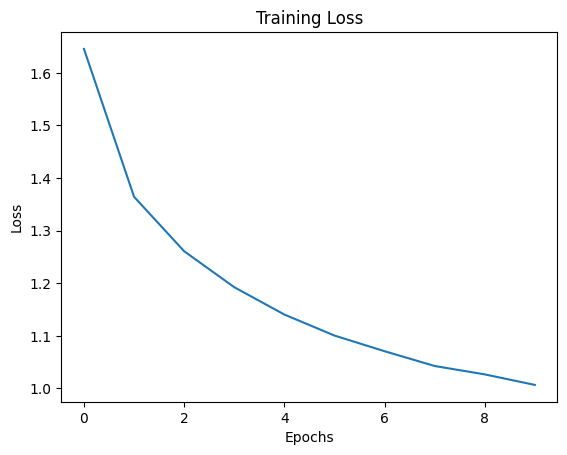

In [7]:
RedCIFAR=CIFAR_NET()
#Define el criterio que usaras para evaluar a la red y un optimizador.
#Y define el preprosesamiento necesario en caso de requerir usar cuda.
criterio = nn.CrossEntropyLoss()
optimizer = optim.Adam(RedCIFAR.parameters(), lr=0.001)
#Entrenamos la red durante 50 pasos(o los que consideres necesarios),con entropia cruzada y el optimizador 
RedCIFAR.train(10,trainloader,criterio,optimizer,cuda=False) #puedes agregar cuda=True si tienes GPU disponible

In [8]:
prec_train =calcularPrecisionGlobal(RedCIFAR,trainloader,4)
prec_val   =calcularPrecisionGlobal(RedCIFAR,testloader,4)
print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train))
print("Precision en conjunto de validacion: %.4f%%"%(prec_val))

Precision en conjunto de entrenamiento: 67.2860%
Precision en conjunto de validacion: 62.5200%


## Ejercicios:
* Crea las funciones necesarias para poder introducir datos concretos a la red (una vez ya entrenada) y obtener el resultado que esta devuelve. Muestra la imagen con la que se está alimentando a la red.
* Con la red neuronal entrenada obten la matriz de confusion de ambos conjuntos (entrenamiento y prueba) con las 10 clases posibles. Para ello en lugar de tener en cuenta únicamente los valores de verdaderos positivos, verdaderos negativos, etc, se usarán los 10 elementos, por lo que debemos tener en cuenta cuantos de cada categoria fueron clasificados incorrectamente, y en cual fue.
* Despues de cada MaxPool normaliza las salidas y contrasta el rendimiento de la red.

### Visualización Resultado Modelo

In [9]:
def test(model, x):
    new_data = np.zeros((32,32,3), float)
    new_data[:,:,0] = x[0]
    new_data[:,:,1] = x[1]
    new_data[:,:,2] = x[2]
    plt.imshow(new_data)
    plt.show()

    output = model.forward(x)

    clas = np.argmax(output.detach().numpy())
    
    print("Predicted class: ", classes[clas])

In [10]:
train_features, train_labels = next(iter(trainloader))

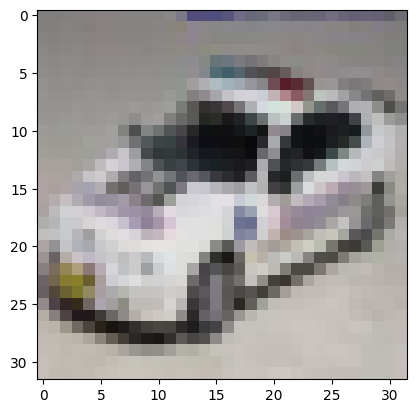

Predicted class:  car


In [11]:
test(RedCIFAR, train_features[0])

### Matriz de confusión

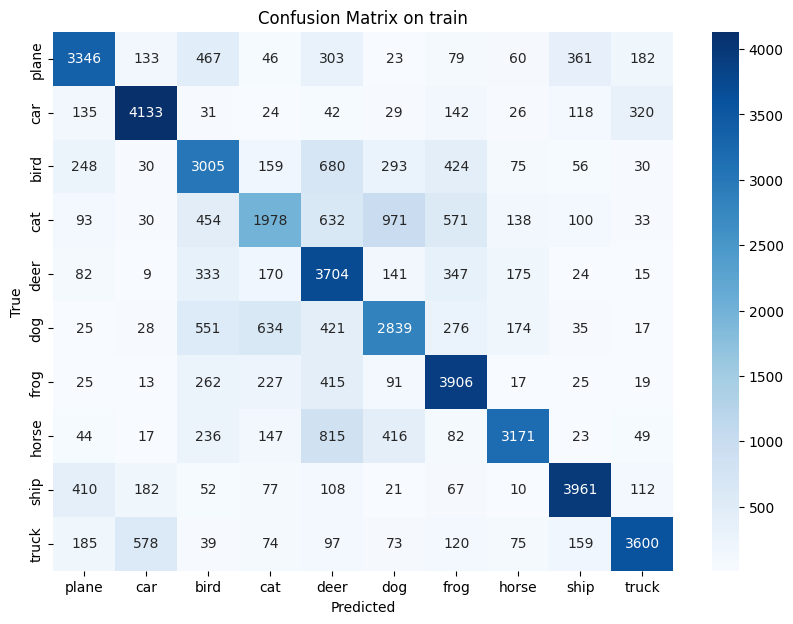

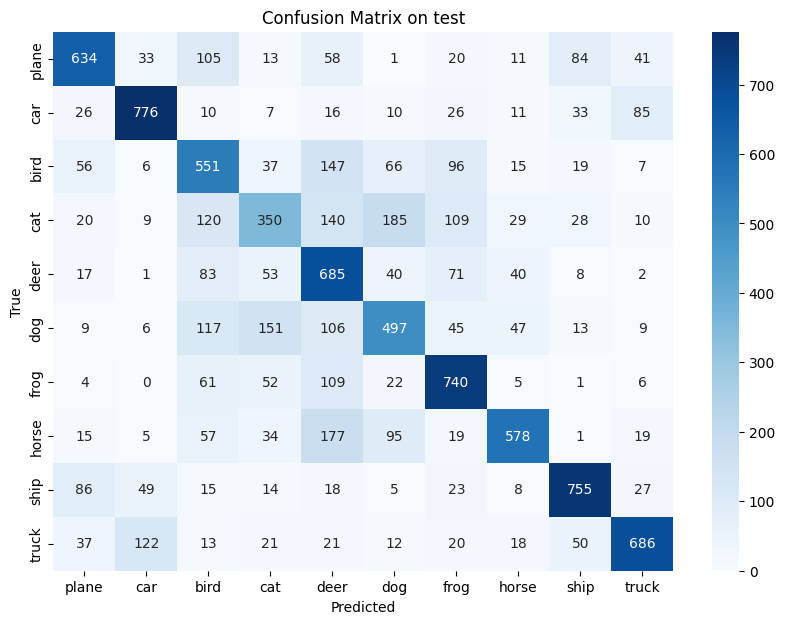

In [12]:
def get_matrix(model, data_loader, classes, name):
    all_preds = []
    all_labels = []
    with torch.no_grad():  
        for data, labels in data_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix on {typeSet}".format(typeSet = name))
    plt.show()

get_matrix(RedCIFAR, trainloader, classes, "train")
get_matrix(RedCIFAR, testloader, classes, "test")

### RED NORMALIZADA


In [13]:
#airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
import torch.nn.functional as F
class CIFAR_NET_N(nn.Module):
    def __init__(self):
        '''
        Construcción de la Red, define las capas que se utiizaran.
        '''
        super(CIFAR_NET_N, self).__init__()
        
        #Toma en cuenta el constructor de las capas convolucionales
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=5,stride=1, padding=1)
        self.pool  = torch.nn.MaxPool2d(kernel_size=3, stride=3, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = torch.nn.Conv2d(64, 32, kernel_size=5,stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(32 * 2 * 2 , 384)  
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)  

    def forward(self, x):
        '''
        Define el orden con el que se realizará la propagación hacia adelante
        de la red.
        '''
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.bn2(x)
        x = x.view(-1, 32 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return (x)
    
    def train(self, epochs, data_loader, criterion, optimizer, cuda=False):
        '''
        Define una función de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza también el caso 
        en que se llegue a utilizar cuda. Muestra una gráfica al finalizar el
        entrenamiento usando el lost obtenido.
        '''
    
        loss_values = [] 
    
        if cuda:
            self.cuda()
    
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(data_loader, 0):
                inputs, labels = data
    
                if cuda:
                    inputs, labels = inputs.cuda(), labels.cuda()
    
                optimizer.zero_grad()
    
                outputs = self.forward(inputs) 
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
                running_loss += loss.item()

            epoch_loss = running_loss / len(data_loader)
            loss_values.append(epoch_loss)
    
        plt.plot(loss_values)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

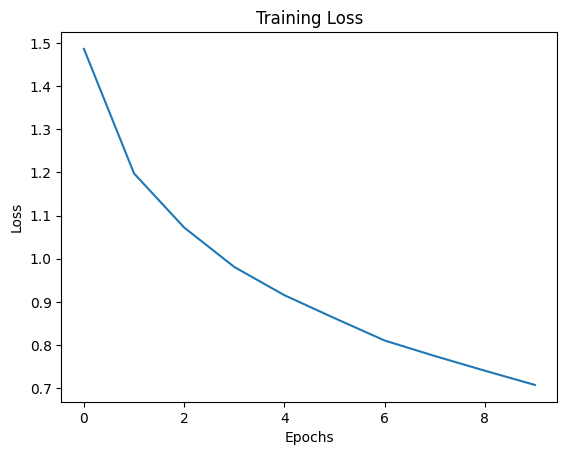

In [14]:
RedCIFAR_N=CIFAR_NET_N()
#Define el criterio que usaras para evaluar a la red y un optimizador.
#Y define el preprosesamiento necesario en caso de requerir usar cuda.
criterio = nn.CrossEntropyLoss()
optimizer = optim.Adam(RedCIFAR_N.parameters(), lr=0.001)
#Entrenamos la red durante 50 pasos(o los que consideres necesarios),con entropia cruzada y el optimizador 
RedCIFAR_N.train(10,trainloader,criterio,optimizer,cuda=False) #puedes agregar cuda=True si tienes GPU disponible

In [18]:
prec_train =calcularPrecisionGlobal(RedCIFAR_N,trainloader,4)
prec_val   =calcularPrecisionGlobal(RedCIFAR_N,testloader,4)
print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train))
print("Precision en conjunto de validacion: %.4f%%"%(prec_val))

Precision en conjunto de entrenamiento: 77.2780%
Precision en conjunto de validacion: 67.2500%


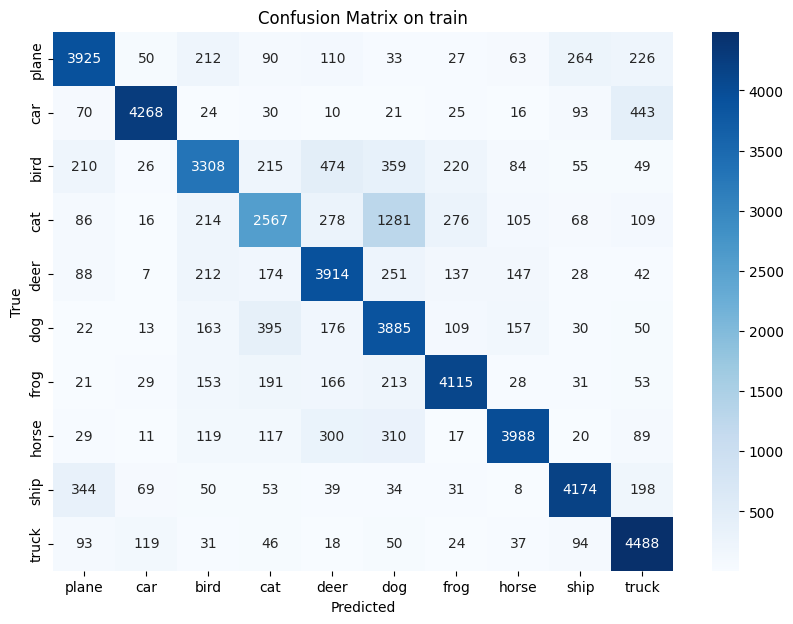

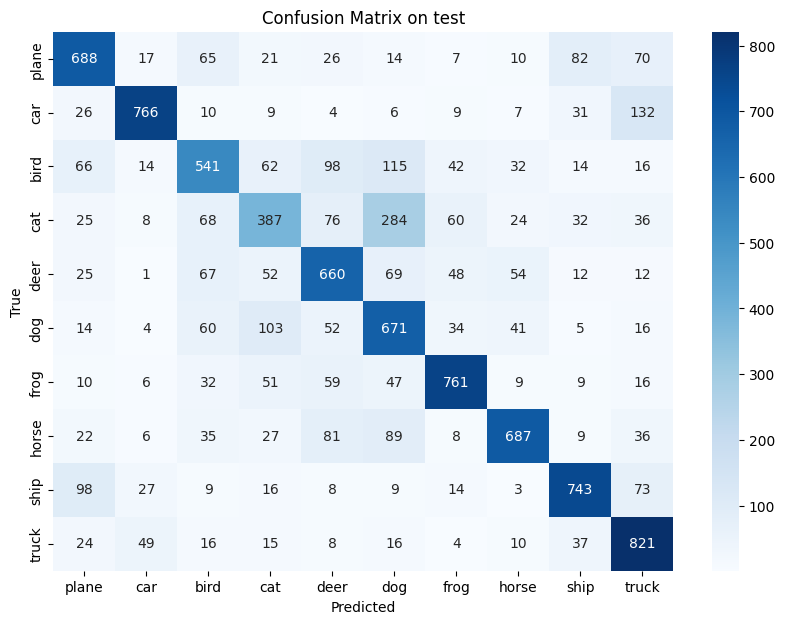

In [16]:
get_matrix(RedCIFAR_N, trainloader, classes, "train")
get_matrix(RedCIFAR_N, testloader, classes, "test")